## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [70]:
!pip install nlp
!pip install -U datasets
!pip install --upgrade datasets


In [71]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [72]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

In [73]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [74]:
# Putting data in form of three different object
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [75]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels


In [76]:
tweets, labels = get_tweet(train)

In [77]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [78]:
#Using in-built tokenizer.
from tensorflow.keras.preprocessing.text import Tokenizer
#Tokenization is the process of converting words to numbers.
#Create corpus of all the words that exist in the dataset and
#give each unique word a unique token.
#Less common words can be given a common token as 'out of the vocabullary'

In [79]:
#Creating a tokenizer object.
#Using 10000 mostly used as a token and the oov as the unlikely string.
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [80]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [81]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

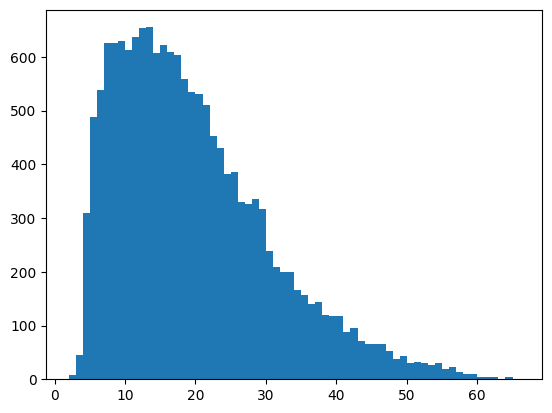

In [82]:
lengths =[len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [83]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [84]:
def get_sequences (tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [85]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [86]:
padded_train_seq[0]
#We taking a max length of 50 value creates a vector of 50 dimension.

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [87]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


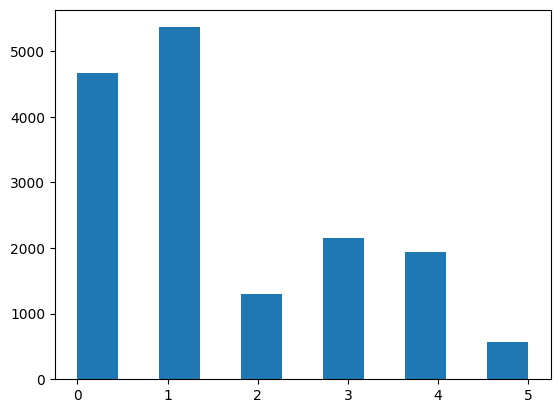

In [88]:
plt.hist(labels, bins=11)
plt.show()

In [89]:
#c is the classname as a key and some numeric value i(key, value) pair.
class_to_index = dict((c,i) for c,i in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [90]:
#Assigns a class value of sadness, joy to a numeric value but the current data set already has a numeric value.
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [91]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [92]:
#Changing all the labels value into respective index.
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [93]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [94]:
# Using Sequential Class From Keras.
model = tf.keras.models.Sequential(
    #Passing List of Layers to Create Our Model.
     [
    #Ten thousand is input dimension.Output dimension is 16.
    #Making each word will be represented using 16 dimensional vector.
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    #20 celled LSTM layers.Return sequence true refer to having ouptut in every time stamp.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences= True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    ############This is the RNN part of our code###############
    #Using 6 units for the 6 classes that we have and softmax activation function.
    tf.keras.layers.Dense(6, activation = 'softmax')
    ])

model.compile(
    #Value of dense layers not being onehot encoded, we use this loss technique.
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics =['accuracy']

  )

In [95]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [96]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences (tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [97]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [98]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy')
    ]
)

Epoch 1/20
500/500 [==============================] - 48s 72ms/step - loss: 1.3137 - accuracy: 0.4734 - val_loss: 0.8068 - val_accuracy: 0.7005
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.6368 - accuracy: 0.7681 - val_loss: 0.6413 - val_accuracy: 0.7685
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.4213 - accuracy: 0.8487 - val_loss: 0.5293 - val_accuracy: 0.8180
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2731 - accuracy: 0.9090 - val_loss: 0.5292 - val_accuracy: 0.8300
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1984 - accuracy: 0.9396 - val_loss: 0.4033 - val_accuracy: 0.8795
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.1464 - accuracy: 0.9554 - val_loss: 0.3589 - val_accuracy: 0.8950
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1060 - accuracy: 0.9682 - val_loss: 0.4418 - val_accuracy: 0.870

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

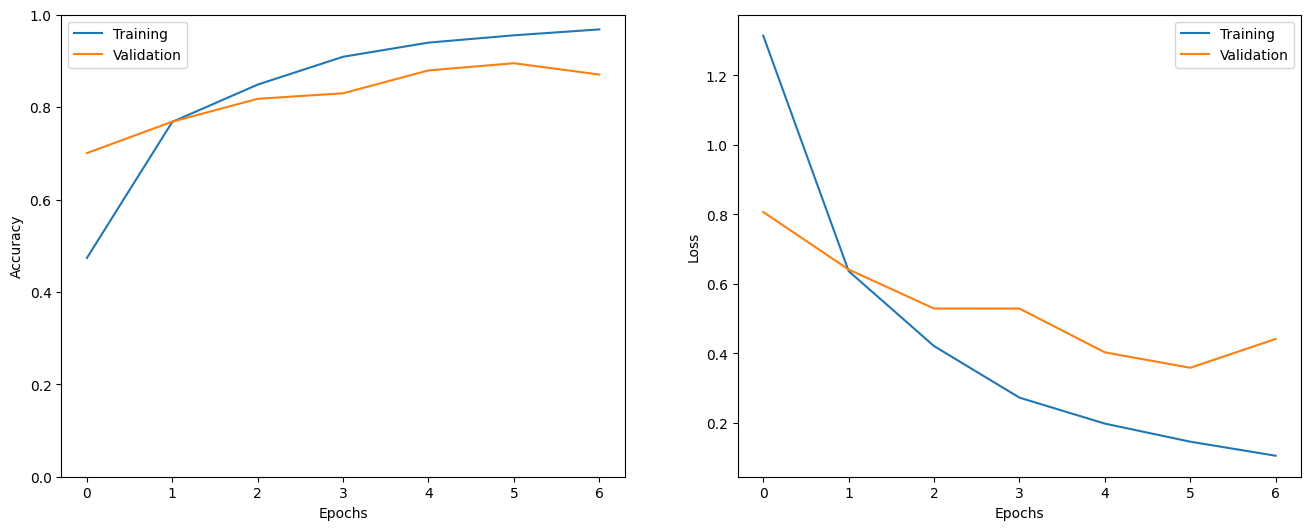

In [99]:
show_history(h)

In [68]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)


In [69]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 3s 7ms/step - loss: 1.7924 - accuracy: 0.1900


In [106]:
i = random.randint(
    0, len(test_labels) - 1
)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i wish there were more times when she just needed me to hold her and rock her to sleep because those are the moments when i feel most successful as father those times when im able to meet all of her needs just by being there for her
Emotion: 1
1/1 [==============================] - 0s 28ms/step
Predicted Emotion: 1


In [109]:
#preds = model.predict_classes(test_seq)
# Get the raw predictions (probabilities for each class)
predictions = model.predict(test_seq)

# Convert the raw predictions to predicted classes
preds = predictions.argmax(axis=-1)


63/63 [==============================] - 1s 9ms/step


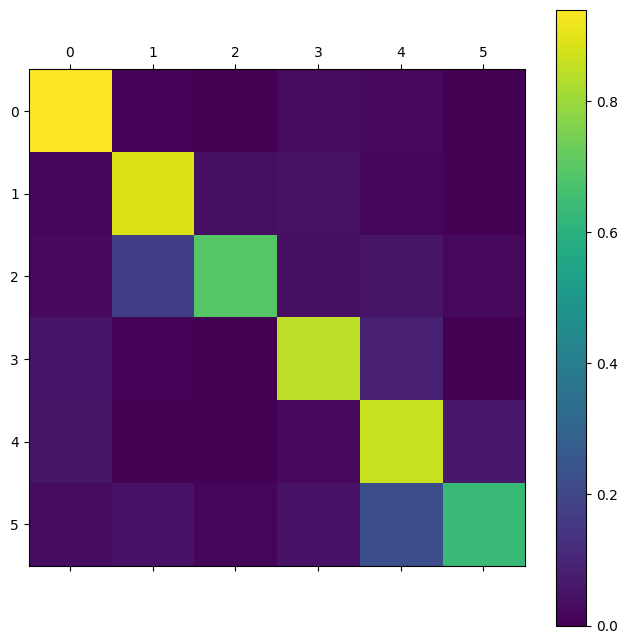

In [110]:
show_confusion_matrix(test_labels, preds, list(classes))